In [1]:
# Core functionality
import os
import traceback
import subprocess

# Plotting and data analysis
import matplotlib.pyplot as plt
import numpy as np

# Molecular and atomic data structures
import MDAnalysis
from MDAnalysis.analysis.rdf import InterRDF

import ase
from ase import io

# For the functional Groups Analysis
import pymatgen
from pymatgen.core import Molecule
from pymatgen.analysis import functional_groups

# For the SOAP similarity analysis
import quippy

In [2]:
def setup_matplotlib_environment():
        # If I decide to generate n colours using a built in colourmap instead.
        # self.colour_generator = color=cm.rainbow(np.linspace(0,1,self.max_num_colours))

        plt.rc('lines', linewidth=4)
        # plt.rc('axes', prop_cycle=(plt.cycler('linestyle', ['-', '--', ':', '-.'])))

        # Font
        plt.rcParams['text.usetex'] = False
        plt.rcParams['font.size'] = 18
        plt.rcParams['legend.fontsize'] = 18

        # Ticks
        plt.rcParams['xtick.direction'] = 'in'
        plt.rcParams['ytick.direction'] = 'in'
        plt.rcParams['xtick.major.size'] = 5.0
        plt.rcParams['xtick.minor.size'] = 3.0
        plt.rcParams['ytick.major.size'] = 5.0
        plt.rcParams['ytick.minor.size'] = 3.0

        # Line width
        plt.rcParams['xtick.major.width'] = 3.0
        plt.rcParams['xtick.minor.width'] = 3.0
        plt.rcParams['ytick.major.width'] = 3.0
        plt.rcParams['ytick.minor.width'] = 3.0
        plt.rcParams['axes.linewidth'] = 2.0

        # Marker Size
        plt.rcParams['lines.markersize'] = 7
        plt.rcParams['lines.markeredgewidth'] = 2.0

        # Legend
        plt.rcParams['legend.handlelength'] = 3.0

setup_matplotlib_environment()

In [3]:
class CHO_Input_Handler:
    """Handle the input of reading files,
    probably using a confusing mixture of
    MDAnalysis and ASE..."""
    
    def __init__(self, root_dirs):
        self.root_dirs = root_dirs
        self.all_pth = {}
        
    def get_replicas(self):
        """For each root dir, get the replica simulations
        found within it. These will all be assumed to be identical"""
        
        for root_dir in self.root_dirs:
            try:
                sub_dirs = os.listdir(root_dir)
                root_dirs = [os.path.join(root_dir, sub_dir) for sub_dir in sub_dirs]
                self.all_pth[root_dir] = root_dirs
            except FileNotFoundError:
                print('\n')
                print(traceback.format_exc())
                print("Root Directory Not Found...\n")
                
        # TEMPORARY PRE-MEETING HACK
        root_dir = self.root_dirs[0]
        try:
            sub_dirs = os.listdir(root_dir)
            root_dirs = [os.path.join(root_dir, sub_dir) for sub_dir in sub_dirs]
            self.all_pth[root_dir] = root_dirs
        except FileNotFoundError:
            print('\n')
            print(traceback.format_exc())
            print("Root Directory Not Found...\n")
                
    def find_all_files(self, suffix):
        """Find all of the files which end with a string matching 
        the variable 'suffix' within the root directories specified.
        
        This function is mostly a helper function for finding .dcd,
        .lammpstrj and .xyz files automatically without the user having
        to specify every directory manually."""
        
        all_files_with_suffix = {}
        for root_dir, sub_dirs in self.all_pth.items():
            all_files_with_suffix[root_dir] = {}
            for sub_dir in sub_dirs:
                files = os.listdir(sub_dir)
                files = [f for f in files if f.endswith(suffix)]
                all_files_with_suffix[root_dir][sub_dir] = files
        
        return all_files_with_suffix
        
    def open_all_lammpstrj(self, engine, flatten=True):
        """Open all of the LAMMPS format 'lammpstrj' files found within
        the root directories.
        
        These can either be flattened into a single list, or stored as a dictionary which will
        preserve the path to the files."""
        
        
        af = self.find_all_files(suffix='.lammpstrj')
        
        if flatten:
            self.all_trj_files_flat = []
        else:
            self.all_trj_files = {}
            
        for root_dir, sub_dirs in af.items():
            for sub_dir, files in sub_dirs.items():
                if flatten:
                    self.all_trj_files_flat.extend([os.path.join(sub_dir, fn) for fn in files])
                else:
                    self.all_trj_files[sub_dir] = [os.path.join(sub_dir, fn) for fn in files]
        
        if flatten:  
            self.all_trj_flat = []
            for fn in self.all_trj_files_flat:

                if engine == 'MDAnalysis':
                    f = MDAnalysis.Universe(fn, topology_format='LAMMPSDUMP')
                elif engine == 'ASE':
                    f = ase.io.read(fn)

                self.all_trj_flat.append(f)
        else:
            self.all_trj = {}
            for sub_dir, files in self.all_trj_files.items():
                self.all_trj[sub_dir] = []
                for fn in files:

                    if engine == 'MDAnalysis':
                        f = MDAnalysis.Universe(fn, topology_format='LAMMPSDUMP')
                    elif engine == 'ASE':
                        f = ase.io.read(fn)

                    self.all_trj[sub_dir].append(f)
                    
    def open_all_cp2k_xyz(self, engine, cell_search_term='.cell'):
        """Open CP2K pos-xyz files.]
        
        only does flat, you'll have to cope with that."""
        
        af = self.find_all_files(suffix='pos-1.xyz')
        all_cell = self.find_all_files(suffix=cell_search_term)
        
        self.all_trj_files_flat = []
        self.all_cp2k_cells = []
        
        for root_dir, sub_dirs in af.items():
            for sub_dir, files in sub_dirs.items():
                self.all_trj_files_flat.extend([os.path.join(sub_dir, fn) for fn in files])
        
        for root_dir, sub_dirs in all_cell.items():
            for sub_dir, files in sub_dirs.items():
                self.all_cp2k_cells.extend([os.path.join(sub_dir, fn) for fn in files])

        self.all_trj_flat = []
        self.all_cp2k_cell_flat = []
        for i, fn in enumerate(self.all_trj_files_flat):
            
            cell = np.genfromtxt(self.all_cp2k_cells[i], usecols=(1, 2, 3))
            
            if engine == 'MDAnalysis':
                f = MDAnalysis.Universe(fn, topology_format='xyz')
                
                # Workaround to get the cell correctly...
                dummy = ase.io.read(fn)
                dummy.set_cell(cell)
                f.dimensions = dummy.get_cell_lengths_and_angles()
                
                f.pbc = True
                
            elif engine == 'ASE':
                f = ase.io.read(fn)
                f.set_cell(cell)
                f.pbc = True

            self.all_trj_flat.append(f)
        
    def open_all_lammps_dcd(self, engine, flatten=True, traj_search_term='.dcd', topo_search_term='.xyz'):
        """Open all of the LAMMPS format DCD files found within the root directories specified.
        
        The code will automatically attempt to match a dcd (or filename found with traj_search_term)
        with a topology file in the same folder, the suffix of which is specified with the variable
        topo_search_term.
        
        These can either be flattened into a single list, or stored as a dictionary which will
        preserve the path to the files."""
        
        af = self.find_all_files(suffix=traj_search_term)
        tf = self.find_all_files(suffix=topo_search_term)
        
        if flatten:
            self.all_trj_files_flat = []
            self.all_topo_files_flat = []
        else:
            self.all_trj_files = {}
            self.all_topo_files = {}
            
        for root_dir, sub_dirs in af.items():
            for sub_dir, files in sub_dirs.items():
                if flatten:
                    self.all_trj_files_flat.extend([os.path.join(sub_dir, fn) for fn in files])
                    self.all_topo_files_flat.extend([os.path.join(sub_dir, fn) for fn in tf[root_dir][sub_dir]])
                else:
                    self.all_trj_files[sub_dir] = [os.path.join(sub_dir, fn) for fn in files]
                    self.all_topo_files[sub_dir] = [os.path.join(sub_dir, fn) for fn in tf[root_dir][sub_dir]]
    
        if flatten:  
            self.all_trj_flat = []
            for i, fn in enumerate(self.all_trj_files_flat):

                if engine == 'MDAnalysis':
                    f = MDAnalysis.Universe(self.all_topo_files_flat[i], fn, format="LAMMPS",
                                            lengthunit="A", timeunit="ps")
                elif engine == 'ASE':
                    raise Exception("ASE Engine won't work with DCD")

                self.all_trj_flat.append(f)
        else:
            self.all_trj = {}
            for sub_dir, files in self.all_trj_files.items():
                self.all_trj[sub_dir] = []
                for i, fn in enumerate(files):

                    if engine == 'MDAnalysis':
                        f = MDAnalysis.Universe(self.all_topo_files[sub_dir][i], fn, format="LAMMPS",
                                            lengthunit="A", timeunit="ps")
                    elif engine == 'ASE':
                        raise Exception("ASE Engine won't work with DCD")
    
                    self.all_trj[sub_dir].append(f)
            
    def open_all_lammps_xtc(self, engine, flatten=True, traj_search_term='.xtc', topo_search_term='.pdb'):
        """Open all of the LAMMPS format DCD files found within the root directories specified.
        
        The code will automatically attempt to match a dcd (or filename found with traj_search_term)
        with a topology file in the same folder, the suffix of which is specified with the variable
        topo_search_term.
        
        These can either be flattened into a single list, or stored as a dictionary which will
        preserve the path to the files."""
        
        af = self.find_all_files(suffix=traj_search_term)
        tf = self.find_all_files(suffix=topo_search_term)
        
        if flatten:
            self.all_trj_files_flat = []
            self.all_topo_files_flat = []
        else:
            self.all_trj_files = {}
            self.all_topo_files = {}
            
        for root_dir, sub_dirs in af.items():
            for sub_dir, files in sub_dirs.items():
                if flatten:
                    self.all_trj_files_flat.extend([os.path.join(sub_dir, fn) for fn in files])
                    self.all_topo_files_flat.extend([os.path.join(sub_dir, fn) for fn in tf[root_dir][sub_dir]])
                else:
                    self.all_trj_files[sub_dir] = [os.path.join(sub_dir, fn) for fn in files]
                    self.all_topo_files[sub_dir] = [os.path.join(sub_dir, fn) for fn in tf[root_dir][sub_dir]]
    
        if flatten:  
            self.all_trj_flat = []
            for i, fn in enumerate(self.all_trj_files_flat):

                if engine == 'MDAnalysis':
                    f = MDAnalysis.Universe(self.all_topo_files_flat[i], fn,
                                            lengthunit="A", timeunit="ps")
                elif engine == 'ASE':
                    raise Exception("ASE Engine won't work with DCD")

                self.all_trj_flat.append(f)
        else:
            self.all_trj = {}
            for sub_dir, files in self.all_trj_files.items():
                self.all_trj[sub_dir] = []
                for i, fn in enumerate(files):

                    if engine == 'MDAnalysis':
                        f = MDAnalysis.Universe(self.all_topo_files[sub_dir][i], fn,
                                            lengthunit="A", timeunit="ps")
                    elif engine == 'ASE':
                        raise Exception("ASE Engine won't work with DCD")
    
                    self.all_trj[sub_dir].append(f)

In [4]:
class Analysis_MDA_RDF:
    """Compute the radial distribution function using MDAnalysis"""
    
    def __init__(self, traj, calc_range=(0.0, 2.0)):
        self.traj = traj
        self.all_rdfs = {}
        self.calc_range = calc_range
        
    def get_unique_elements_in_traj(self, traj):
        """Find the unique elements for one trajectory"""
        
        at = traj.select_atoms('all')
        return set(at.elements)
    
    def get_unique_elements_all(self):
        """Find the unique elements across all trajectories"""
        
        self.unique_elements = set([])
        for traj in self.traj:
            # self.unique_elements = self.unique_elements | self.get_unique_elements_in_traj(traj)
            # Temporary fix for element info not being read from .pdb (use converted .xyz for topo?)
            self.unique_elements = ['C']
        self.unique_elements = list(self.unique_elements)
    
    def compute_mda_rdf(self, traj, e1, e2, nbins=75):
        """Function to compute one individual rdf..."""
        
        traj.trajectory[-1]
        
        g1 = traj.select_atoms("name " + str(e1))
        g2 = traj.select_atoms("name " + str(e2))
                
        rdf = InterRDF(g1, g2, nbins=nbins, range=self.calc_range)
        rdf.run()
        
        return(rdf.bins, rdf.rdf)
    
    def compute_all_mda_rdf(self, e1, e2, nbins=75):
        "Compute all the replica RDFs for a given pair of atoms"
        
        atom_pair = str(e1) + '-' + str(e2)
        self.all_rdfs[atom_pair] = []
        
        for traj in self.traj:
            self.all_rdfs[atom_pair].append(self.compute_mda_rdf(traj, e1, e2, nbins=nbins))
        
        return self.all_rdfs[atom_pair]
            
    def compute_all_mda_rdf_all_element_pairs(self, nbins=75):
        """Loop over all atom pairs, and compute rdfs for all trajectories"""
        
        # First determine what the unique elements are
        self.get_unique_elements_all()

        for e1 in self.unique_elements:
            for e2 in self.unique_elements:
                self.compute_all_mda_rdf(e1, e2, nbins=nbins)
                
        return self.all_rdfs

In [5]:
class Plotter_MDA_RDF:
    """rdf_data should be a variable (ideally provided by the Analysis_MDA_RDF object),
    which is a dictionary of the format {'E1-E2': [[bins1][data1],
                                                   [bins2][data2]],
                                         'E1-E2': [[bins1][data1],
                                                   [bins2][data2]]
                                                   ...
                                                   ...}

    where E1 and E2 are the two elements within which to compute the RDF."""
    
    def __init__(self, rdf, name=''):
        self.rdf_obj = rdf
        self.name = name
        self.rdf_data = self.rdf_obj.all_rdfs
        
        # Get the unique elements from the trajectories
        self.rdf_obj.get_unique_elements_all()
        self.unique_elements = self.rdf_obj.unique_elements
        
        self.colour = 'royalblue'
        
        self.reference = False
        
    def add_reference(self, ref_rdf):
        self.ref_rdf_obj = ref_rdf
        self.ref_rdf_data = self.ref_rdf_obj.all_rdfs
        
        # Get the unique elements from the trajectories
        self.ref_rdf_obj.get_unique_elements_all()
        self.ref_unique_elements = self.ref_rdf_obj.unique_elements
        
        self.ref_colour = 'firebrick'
        self.reference = True
    
    def average_all_rdfs(self, do_reference=False):
        
        if do_reference:
            self.ref_averaged_rdfs = {}
            to_avg_rdf_data = self.ref_rdf_data
        else:
            self.averaged_rdfs = {}
            to_avg_rdf_data = self.rdf_data
                    
        for atom_pair, data in to_avg_rdf_data.items():
            if do_reference:
                self.ref_averaged_rdfs[atom_pair] = []
            else:
                self.averaged_rdfs[atom_pair] = []

            all_bins = []
            all_rdf = []
            
            [all_bins.append(replica[0]) for replica in data]
            [all_rdf.append(replica[1]) for replica in data]
            
            bins_avg = np.mean(np.array(all_bins), axis=0)
            rdf_avg = np.mean(np.array(all_rdf), axis=0)
            
            if do_reference:
                self.ref_averaged_rdfs[atom_pair] = (bins_avg, rdf_avg)
            else:
                self.averaged_rdfs[atom_pair] = (bins_avg, rdf_avg)
            
    def plot_all_rdfs(self):
        
        self.average_all_rdfs()
        
        if self.reference:
            self.average_all_rdfs(do_reference=True)
        
        fig, axes = plt.subplots(ncols=1, nrows=1, sharex=True, sharey=True, figsize=(6, 6), squeeze=False)
        
        axes = axes.flatten()
        
        ax_i = 0
        for i, e1 in enumerate(self.unique_elements):
            for j, e2 in enumerate(self.unique_elements):
                if i <= j:
                    key = str(e1) + "-" + str(e2)

                    # Plot the individual trajectories
                    if self.reference:
                        for replica in self.ref_rdf_data[key]:
                            axes[ax_i].plot(replica[0],
                                            replica[1], 
                                            alpha=0.1, 
                                            color=self.ref_colour, 
                                            linewidth=2)
                    
                    for replica in self.rdf_data[key]:
                        axes[ax_i].plot(replica[0], 
                                        replica[1], 
                                        alpha=0.1, 
                                        color=self.colour, 
                                        linewidth=2)
                    
                    if self.reference:
                        axes[ax_i].plot(self.ref_averaged_rdfs[key][0], 
                                        self.ref_averaged_rdfs[key][1], 
                                        color=self.ref_colour,
                                        label='DFT')
                        
                    axes[ax_i].plot(self.averaged_rdfs[key][0], 
                                    self.averaged_rdfs[key][1], 
                                    color=self.colour,
                                    label='GAP')
                    
                    axes[ax_i].set_title(str(e1) + ' - ' + str(e2))
                    axes[ax_i].hlines(1, 
                                      xmin=min(self.averaged_rdfs[key][0]), 
                                      xmax=max(self.averaged_rdfs[key][0]), 
                                      color='k', linestyle='dashed', linewidth=2)
                    axes[ax_i].set_xlim(min(self.averaged_rdfs[key][0]), max(self.averaged_rdfs[key][0]))
                    # axes[ax_i].set_ylim(ymin=0)
                    axes[ax_i].set_yticks([])
                    
                    if self.reference:
                        axes[ax_i].set_ylim(ymax=10)
                    
                    ax_i +=1 
                
        plt.subplots_adjust(hspace=0.3, wspace=0.3)
        
        if self.reference:
            plt.legend(frameon=False)
        
        data = np.array(self.averaged_rdfs[key][0])
        for i, e1 in enumerate(self.unique_elements):
            for j, e2 in enumerate(self.unique_elements):
                if i <= j:
                    key = str(e1) + "-" + str(e2)
                    data = np.vstack((data, self.averaged_rdfs[key][1]))
        
        np.savetxt(self.name + "RDF_Data.txt", data.T)
        plt.savefig(self.name+"All_RDFs_v2.png", format='png', dpi=200, bbox_inches='tight')

In [6]:
class Rings_Analyser:
    """For Performing the rings analysis and computing the coordination
    fractions."""
    
    def __init__(self, traj):
        self.traj = traj
        
        # Variables related to the rings code.
        self.exe_path = "/Users/patrickrowe/Software/Rings/rings2.out"
        
    def conv_f_to_rings_inp(self, frame, index, elements, write=False):
        """Convert a frame into a string that the 
        rings code can use as its input
        
        the input is an XYZ as follows:
        
        time step #atoms
        boxx boxy boxz
        x y z
        . . ."""
        
        selection_str = 'name '
        for e in elements:
            selection_str += str(e) + ' '
            
        at = frame.select_atoms(selection_str)
        
        # Go to last frame
        frame.trajectory[index]
                
        struct_string = ''
        struct_string += '1 1 ' + str(len(at)) + '\n'
        vec_string = np.array2string(frame.dimensions).replace('[', '').replace(']', '')
        struct_string += vec_string + '\n'
        pos_string = np.array2string(at.positions, precision=8, threshold=999999,
                                    formatter={'float_kind':lambda x: "%.8f" % x})
        pos_string = pos_string.replace('[', '').replace(']', '')
        
        for line in pos_string.splitlines():
            struct_string += line.strip() + '\n'
        
        struct_string += '\n'
        
        if write:
            with open("frame.rings_txt", "w") as f:
                f.write(struct_string)
        
        return struct_string
        
    def run_rings_frame(self, rings_str, verbose=False):
        """Take a string/file in the rings
        input format and call the executable to 
        perform the rings analysis."""
        
        p = subprocess.run(self.exe_path, stdout=subprocess.PIPE, 
                           stderr=subprocess.PIPE,
                           input=rings_str, encoding='ascii')
        
        if verbose:
            print("\nReturnCode\n")
            print(p.returncode)
            print("\nSTDERR\n")
            print(p.stderr)
            print("\nSTDOUT\n")
            print(p.stdout)
        
        return p.stdout
    
    def parse_rings_output(self, output_str):
        
        neighbours = []
        rings = []
        rings_sizes = []
        
        ring_n = 3
        
        for line in output_str.splitlines():
            line = line.strip()
            
            if line.startswith("Zero or One"):    
                neighbours.append(float(line.split(" ")[-1]))
            elif line.startswith("Two neighbours"):
                neighbours.append(float(line.split(" ")[-1]))
            elif line.startswith("Three neighbours"):
                neighbours.append(float(line.split(" ")[-1]))
            elif line.startswith("Four neighbours"):
                neighbours.append(float(line.split(" ")[-1]))
            elif line.startswith("Five or more"):
                neighbours.append(float(line.split(" ")[-1]))
            
            if line.startswith("Size"):
                rings.append(int(line.split(" ")[-1]))
                rings_sizes.append(ring_n)
                ring_n += 1
                
        return neighbours, rings, rings_sizes
    
    def run_all_rings_last_frame(self, elements):
        
        self.all_neighbours = []
        self.all_rings = []
        self.all_rings_sizes = []
        
        for traj in self.traj:
            rings_str = self.conv_f_to_rings_inp(traj, index=-1, elements=elements, write=True)
            string = self.run_rings_frame(rings_str)
            neighbours, rings, rings_sizes = self.parse_rings_output(string)
            self.all_neighbours.append(neighbours)
            self.all_rings.append(rings)
            self.all_rings_sizes.append(rings_sizes)
    
    def run_all_rings_n_frame(self, elements, n_frames, n_skip):
        
        self.step_neighbours = []
        self.step_rings = []
        self.step_rings_sizes = []
        
        for traj in self.traj:
            self.step_neighbours.append([])
            self.step_rings.append([])
            self.step_rings_sizes.append([])
            for step in np.linspace(n_skip, len(traj.trajectory) - 1, n_frames):
                step = int(step)
                rings_str = self.conv_f_to_rings_inp(traj, index=step, elements=elements, write=True)
                string = self.run_rings_frame(rings_str)
                neighbours, rings, rings_sizes = self.parse_rings_output(string)
                self.step_neighbours[-1].append(neighbours)
                self.step_rings[-1].append(rings)
                self.step_rings_sizes[-1].append(rings_sizes)
        

In [7]:
class Rings_Plotter:
    
    def __init__(self, rings_analyser, name=''):
        self.name = name
        self.rings_analyser = rings_analyser
        
        # For the averaged 'final frame' plot
        self.rings = rings_analyser.all_rings
        self.rings_sizes = rings_analyser.all_rings_sizes[0]
        self.neigh = rings_analyser.all_neighbours
        
        # For the time resolved plot
        self.step_rings = rings_analyser.step_rings
        self.step_rings_sizes = rings_analyser.step_rings_sizes[0]
        self.step_neigh = rings_analyser.step_neighbours
        
        self.n_neigh = [1, 2, 3, 4, 5]
        self.n_neigh_labels = ['$\leq 1$', '2', '3', '4', '$\geq 5$']

        # Blue colours
        self.colours_blue = ['#3F00FF', 
                             '#6082B6', 
                             '#00A36C', 
                             '#CCCCFF', 
                             '#0818A8',
                             '#50C878',
                             '#808000',
                             '#93C572',
                             '#00FF7F']
        
        self.markers = ['x', 'v', '^', 's', '+', 'd', '2', '*', 'p']
        
        self.colour = 'royalblue'
        
        self.reference = False
        
    def add_reference(self, rings_analyser):
        """Add a rings analyser to be used as a reference"""
        
        # For the averaged 'final frame' plot
        self.ref_rings_analyser = rings_analyser
        self.ref_rings = rings_analyser.all_rings
        self.ref_rings_sizes = rings_analyser.all_rings_sizes
        self.ref_neigh = rings_analyser.all_neighbours
        
        # For the time resolved plot
        self.ref_step_rings = rings_analyser.step_rings
        self.ref_step_rings_sizes = rings_analyser.step_rings_sizes
        self.ref_step_neigh = rings_analyser.step_neighbours
        
        self.ref_colour = 'firebrick'
        self.reference = True
        
    def average_all_replicas(self, do_reference=False):
        self.ring_sizes = self.rings_sizes
        
        if self.reference:
            self.ref_averaged_rings = np.mean(np.array(self.ref_rings), axis=0)
            self.ref_averaged_neigh = np.mean(np.array(self.ref_neigh), axis=0)
            self.ref_step_averaged_rings = np.mean(np.array(self.ref_step_rings), axis=0)
            self.ref_step_averaged_neigh = np.mean(np.array(self.ref_step_neigh), axis=0)
        else:
            self.averaged_rings = np.mean(np.array(self.rings), axis=0)
            self.averaged_neigh = np.mean(np.array(self.neigh), axis=0)
            self.averaged_step_rings = np.mean(np.array(self.step_rings), axis=0)
            self.averaged_step_neigh = np.mean(np.array(self.step_neigh), axis=0)
            

    def plot_step_rings(self):
        fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7,7))
        
        # Convert to a numpy array and normalise so that the total for each step is 1
        # step_rings = np.array(self.step_rings) / np.array(self.step_rings).sum(axis=0)
        step_rings = np.array(self.averaged_step_rings) / np.array(self.averaged_step_rings).max(axis=0)
        
        # NOTE: NOT TESTED AND NOT IN USE
        if self.reference:
            for i, ring_size in enumerate(self.ref_rings_sizes):
                ax.plot(np.arange(len(ref_step_rings)), 
                        self.averaged_ref_step_rings[:, i], 
                        marker='o', label='DFT',)
        # END NOT TESTED
       
        for i, ring_size in enumerate(self.rings_sizes):
            print(str(i) + " : " + str(ring_size))
            # NOTE: Temporary indexing here instead of timestep based on 'n_frames' needs to be corrected 
            ax.plot(np.arange(len(step_rings)), 
                    self.averaged_step_rings[:, i], 
                    marker=self.markers[i], label=str(ring_size),
                    color=self.colours_blue[i])
                
        # ax.set_xticks(np.arange(len(step_rings[:,1])))
        # ax.set_xticklabels(self.ring_sizes)
        ax.set_ylim(ymin=0)
        ax.set_xlabel("Step")
        ax.set_ylabel("Frequency")
        ax.set_title("Time Resolved Rings Statistics")
        
        plt.legend(frameon=False)
        
        # NOTE: Temporary indexing here instead of timestep based on 'n_frames' needs to be corrected 
        np.savetxt(self.name + "Step_Rings_Data.txt", np.vstack((np.arange(len(step_rings)), np.array(self.averaged_step_rings).T)).T)
        plt.savefig(self.name + "Step_Rings.png", format='png', dpi=200, bbox_inches='tight')
    
    def plot_step_neighbours(self):
        fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7,7))
        
        # Plot the individual trajectories first
        if self.reference:
            for i, neigh in enumerate(self.n_neigh):
                ax.plot(np.arange(len(self.averaged_ref_step_neigh)),
                self.averaged_ref_step_neigh[:, i], linewidth=2,
                marker='o', label=neigh)

        for i, neigh in enumerate(self.n_neigh):
            # NOTE: Temporary indexing here instead of timestep based on 'n_frames' needs to be corrected 
            ax.plot(np.arange(len(self.averaged_step_neigh)),
                    self.averaged_step_neigh[:, i], linewidth=2,
                    marker=self.markers[i], label=neigh, 
                    color=self.colours_blue[i])


        # ax.set_xticks(np.arange(len(self.step_neigh[:,0])))
        # ax.set_xticklabels(np.arange(len(self.step_neigh[:,0])))
        ax.set_ylim(ymin=0)
        ax.set_xlabel("Step")
        ax.set_ylabel("Population [%]")
        ax.set_title("Time Resolved Coordination Statistics")

        plt.legend(frameon=False)

        # NOTE: Temporary indexing here instead of timestep based on 'n_frames' needs to be corrected 
        np.savetxt(self.name + "Step_Neighbours_Data.txt", np.vstack((np.arange(len(self.averaged_step_neigh)), np.array(self.averaged_step_neigh).T)).T)
        plt.savefig(self.name + "Step_Coordination_Fractions.png", format='png', dpi=200, bbox_inches='tight')
        
    def plot_rings(self):
        fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7,7))
        
        if self.reference:
            for rings_replica in self.ref_rings:
                ax.plot(self.ring_sizes, 
                        np.array(rings_replica) / sum(rings_replica), 
                        color=self.ref_colour, 
                        alpha=0.3, 
                        linewidth=2)
        
        # Plot the individual trajectories first
        for rings_replica in self.rings:
            ax.plot(self.ring_sizes, 
                    np.array(rings_replica) / sum(rings_replica), 
                    color=self.colour, 
                    alpha=0.3, 
                    linewidth=2)
        
        if self.reference:
            ax.plot(self.ring_sizes, 
                    np.array(self.ref_averaged_rings) / sum(self.ref_averaged_rings), 
                    color=self.ref_colour, marker='o', label='DFT')
        
        ax.plot(self.ring_sizes, 
                np.array(self.averaged_rings) / sum(self.averaged_rings), 
                color=self.colour, marker='o', label='GAP')
                
        ax.set_xticks(self.ring_sizes)
        ax.set_xticklabels(self.ring_sizes)
        ax.set_ylim(ymin=0)
        ax.set_xlabel("Ring Size")
        ax.set_ylabel("Frequency")
        ax.set_title("Rings Statistics")
        
        if self.reference:
            plt.legend(frameon=False)
            
            
        np.savetxt(self.name + "Rings_Data.txt", np.vstack((self.ring_sizes, self.averaged_rings, self.rings)).T)
        plt.savefig(self.name + "All_Rings.png", format='png', dpi=200, bbox_inches='tight')
        
    def plot_neighbours(self):
        fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7,7))
        
        # Plot the individual trajectories first
        if self.reference:
            for neigh_replica in self.ref_neigh:
                ax.plot(self.n_neigh, neigh_replica, color=self.ref_colour, alpha=0.3, linewidth=2)
            
        for neigh_replica in self.neigh:
            ax.plot(self.n_neigh, neigh_replica, color=self.colour, alpha=0.3, linewidth=2)
        
        if self.reference:
            ax.plot(self.n_neigh, self.ref_averaged_neigh, color=self.ref_colour, marker='o', label='DFT')
            
        ax.plot(self.n_neigh, self.averaged_neigh, color=self.colour, marker='o', label='GAP')
        
        ax.set_xticks(self.n_neigh)
        ax.set_xticklabels(self.n_neigh_labels)
        ax.set_ylim(ymin=0)
        ax.set_xlabel("Coordination Fraction")
        ax.set_ylabel("Population [%]")
        if self.reference:
            plt.legend(frameon=False)
        ax.set_title("Coordination Statistics")
        
        print("Number of neighbours > 5: {}".format(self.averaged_neigh[-1]) )
        
        np.savetxt(self.name + "Coordination_Fractions_Data.txt", np.vstack((self.n_neigh, self.averaged_neigh, self.neigh)).T)
        plt.savefig(self.name + "All_Coordination_Fractions.png", format='png', dpi=200, bbox_inches='tight')

In [8]:
class Functional_Groups_Plotter:
    
    def __init__(self, functional_groups_analyser, name=''):
        self.fg_analyser = functional_groups_analyser
        self.all_groups_all_frames = self.fg_analyser.all_groups_all_frames
        self.name = name
        
    def sum_all_fg_dictionaries(self, avg=True):
        """plotter object is given data as a list of n
        dictionaries. Got to sum over these to count the
        functional groups in N frames...
        
        'fg': stands for functional group"""
        
        self.sum_all_fgs = {}
        
        for fg_frame in self.all_groups_all_frames:
            for fg, fg_dict in fg_frame.items():
                count = fg_dict['count']
                
                # If it's a new functional group, add it to master dict
                if fg not in self.sum_all_fgs.keys():
                    self.sum_all_fgs[fg] = count
                # Otherwise add it to the sum...
                else:
                    self.sum_all_fgs[fg] += count
        
        if avg:
            for fg, count in self.sum_all_fgs.items():
                self.sum_all_fgs[fg] /= len(self.all_groups_all_frames)
                
    def plot_all_fgs(self):
        
        len_plot = len(self.sum_all_fgs)
        point_positions = range(1, len_plot+1)
        
        sorted_fgs = {k: v for k, v in sorted(self.sum_all_fgs.items(), 
                                              key=lambda item: item[1], 
                                              reverse=True)}
        
        fg_names, count = list(sorted_fgs.keys()), list(sorted_fgs.values())
        
        fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5,5))
        
        ax.plot(point_positions, count, marker='o', linestyle='dashed')
        ax.set_xticks(point_positions)
        ax.set_xticklabels(fg_names, rotation=90)
        ax.set_ylabel("Functional Group Count")
        plt.savefig(self.name+'Functional_Groups_Analysis.png', format='png', dpi=200, bbox_inches='tight')

In [9]:
class Functional_Groups_Analyser:
    """Analyse the functional groups present in a structure."""
    
    def __init__(self, traj):
        self.traj = traj
        
        self.all_groups_all_frames = []
        
    def compute_functional_groups_frame(self, frame, index, do_catch_basic=False, cutoff=2.0, do_cutoff=True):
        
        # Create a molecule
        at = frame.select_atoms("all")
        
        # Go to a particular index (probably the last)
        frame.trajectory[index]
        
        # Get the positions and element types and make an ASE
        # Object for convenience (pymatgen doesn't like the elements otherwise)
        positions = at.positions
        symbols = ''.join(at.atoms.types)
        ase_atoms = ase.Atoms(symbols, positions)
        
        io.write("./atoms_before_deletion.xyz", ase_atoms, format='extxyz')
        
        if do_cutoff:
            del_inx = []
            c_inx = [atom.index for atom in ase_atoms if atom.symbol == 'C']
            x_inx = [atom.index for atom in ase_atoms if atom.symbol != 'C']

            for c in c_inx:
                all_distances = ase_atoms.get_distances(c, x_inx, mic=False)

                if all_distances.min() > cutoff:
                    del_inx.append(c)
            
            deleted_atoms = ase_atoms[del_inx]
            
            del ase_atoms[del_inx]
        
        io.write("./atoms_after_deletion.xyz", ase_atoms, format='extxyz')
        io.write("./deleted_atoms.xyz", deleted_atoms, format='extxyz')
        
        debug = False
        if debug:
            import random
            all_files = os.listdir("./Debug")
            # Load in an example molecule
            molecules = [io.read(os.path.join("./Debug", fn, "Final_Frame.xyz")) for fn in all_files]
            ase_atoms = random.choice(molecules)
        
        # Make a pymatgen molecule and do the analysis.
        mol = Molecule(ase_atoms.symbols, ase_atoms.positions)
        f_groups = functional_groups.FunctionalGroupExtractor(mol, optimize=False)
        all_groups = f_groups.get_all_functional_groups(catch_basic=do_catch_basic)
        
        # Categorise The Functional Groups
        categorised_all_groups = f_groups.categorize_functional_groups(all_groups)
        
        return categorised_all_groups
        
    def compute_all_functional_groups_all_frames(self, do_catch_basic=False):
        """Do the functional groups analysis for every frame in the trajectory"""
        
        for frame in self.traj:
            self.all_groups_all_frames.append(self.compute_functional_groups_frame(frame, 
                                                                                   index=-1, 
                                                                                   do_catch_basic=do_catch_basic))

In [10]:
class SOAP_Similarity_Wrapper:
    """Wrapper for some application specific functions
    
    just to keep things clean"""
    
    def __init__(self, soap_analyser):
        self.ref_paths = {"Graphite": "/Users/patrickrowe/Documents/Research/CHO_GAP/1_Structure_Generation/3_Reference_States/1_Initial_Optimisations/1_Graphite/graphite.POSCAR",
                          "Diamond":"/Users/patrickrowe/Documents/Research/Carbon_Potential/1_Potential_Development/Defect_Structure/Reference_Structures/Diamond_Large/POSCAR",
                          "Nanotube":"/Users/patrickrowe/Documents/Research/Carbon_Potential/1_Potential_Development/Defect_Structure/Reference_Structures/Nanotube_9_9/POSCAR",
                          "Fullerene":"/Users/patrickrowe/Documents/Research/Carbon_Potential/1_Potential_Development/Defect_Structure/Reference_Structures/C60/POSCAR"}
        self.soap_analyser = soap_analyser
        
    def do_all_soaps(self):
        for name, path in self.ref_paths.items():
            self.soap_analyser.set_reference_struct(path, name)
            self.soap_analyser.compute_similarity_all_final_frames()
    
    def do_step_soaps(self, n_frames, n_skip):
        for name, path in self.ref_paths.items():
            self.soap_analyser.set_reference_struct(path, name)
            self.soap_analyser.compute_step_similarities(n_frames=n_frames, 
                                                         n_skip=n_skip)

In [11]:
class SOAP_Plotter:
    """Plotter and printer for soap similarity data"""
    
    def __init__(self, soap_analyser, name):
        self.soap_analyser = soap_analyser
        self.name = name
        
    def print_soap_similarities(self):
        print_text = ''
        buffer_text = "="*20 + '\n'
        
        print_text += "SOAP Similarity information for: {}\n".format(self.name) 
        print_text += buffer_text
        print_text += "SOAP String: " + self.soap_analyser.soap_string + "\n"
        print_text += buffer_text
        print_text += "SOAP Similarities:\n"
        
        for name, similarity in self.soap_analyser.soap_similarities.items():
            print(similarity)
            print_text += name + ":  " + str(np.around(np.average(similarity), decimals = 3)) + "\n"
            
        print(print_text)
        with open(self.name + "SOAP_Similarity.txt", 'w') as f:
            f.write(print_text)
    
    def print_step_soap_similarities(self):
        print_text = ''
        buffer_text = "="*20 + '\n'
        
        print_text += "Per Step SOAP Similarity information for: {}\n".format(self.name) 
        print_text += buffer_text
        print_text += "SOAP String: " + self.soap_analyser.soap_string + "\n"
        print_text += buffer_text
        print_text += "SOAP Similarities:\n"
        
        data = []

        for name, similarity in self.soap_analyser.step_soap_similarities.items():
            data.append(similarity)
        print(data)
        new_str = ''.join(data)
        print_text += new_str
        
        print(print_text)
        with open(self.name + "Step_SOAP_Similarity.txt", 'w') as f:
            f.write(print_text)

In [12]:
class SOAP_Similarity_Analyser:
    """Class for examining the similarity between two structures
    by computing the dot product of SOAP vectors between them."""
    
    def __init__(self, traj):
        self.traj = traj
        
        self.soap_similarities = {}
        self.step_soap_similarities = {}
        self.kernels = {}
        
    def set_reference_struct(self, ref_struct_path, name=None):
        self.ref_struct_path = ref_struct_path
        self.ref_struct = io.read(ref_struct_path)
        
        if name == None:
            self.ref_name = self.ref_struct_path
        else:
            self.ref_name = name
        
        if self.ref_name not in self.soap_similarities.keys():
            self.soap_similarities[self.ref_name] = []
        if self.ref_name not in self.step_soap_similarities.keys():
            self.step_soap_similarities[self.ref_name] = []
        if self.ref_name not in self.kernels.keys():
            self.kernels[self.ref_name] = []
        
    def set_soap_string(self, soap_string):
        self.soap_string = soap_string
        self.descriptor = quippy.descriptors.Descriptor(soap_string)
        
    def get_ase_from_mdtraj(self, traj, index, pbc, selection='all'):
        # Create a molecule
        at = traj.select_atoms(selection)
        
        # Go to a particular index (probably the last)
        traj.trajectory[index]
        
        # Get the positions and element types and make an ASE
        # Object so we can compute
        if pbc:
            cell = traj.dimensions

        positions = at.positions
        symbols = ''.join(at.atoms.types)
        ase_atoms = ase.Atoms(symbols, positions, cell=cell)
        
        if pbc:
            ase_atoms.pbc = True
        
        return ase_atoms
        
    def compute_similarity_frame(self, traj, index=-1, mode='average'):
        frame = self.get_ase_from_mdtraj(traj, index, pbc=True, selection='name C')
        ref = self.ref_struct.copy()
        
        self.frame_soap = self.descriptor.calc(frame)['data']
        self.ref_soap = self.descriptor.calc(ref)['data']
        
        # Stupid long winded way of doing it
        # n_at_ref = len(soap_analyser.ref_struct)
        # n_at_test = len(soap_analyser.traj[0].trajectory[0])
        # kernel = np.zeros((n_at_ref, n_at_test))
        # for i in range(n_at_ref):
        #     for j in range(n_at_test):
        #         kernel[i, j] = np.dot(soap_analyser.ref_soap[i, :], 
        #                               soap_analyser.frame_soap[j, :])
        
        kernel = np.dot(self.ref_soap, self.frame_soap.T)
        
        if mode == 'average':
            return kernel, np.average(kernel)
        elif mode == 'max':
            return kernel, np.max(kernel)
        elif mode == 'min':
            return kernel, np.min(kernel)
            
    def compute_similarity_all_final_frames(self, mode='average'):
        for traj in self.traj:
            kernel, soap_similarity = self.compute_similarity_frame(traj, index=-1)
            self.kernels[self.ref_name].append(kernel)
            self.soap_similarities[self.ref_name].append(soap_similarity)
            
    def compute_step_similarities(self, mode='average', n_frames=5, n_skip=0):
        for traj in self.traj:
            for step in np.linspace(n_skip, len(traj.trajectory) - 1, n_frames):
                step = int(step)
                kernel, step_soap_similarity = self.compute_similarity_frame(traj, index=step)
                self.step_soap_similarities[self.ref_name].append(step_soap_similarity)

In [13]:
class CHO_Analyser:
    """Class for controlling the analysis of many CHO trajectories"""
    
    def __init__(self, test_dirs, name=''):
        self.io = CHO_Input_Handler(test_dirs)
        self.name = name
        
    def read_trajectories(self, traj_type, engine='MDAnalysis', flatten=True):
        self.io.get_replicas()
        self.engine = engine
        
        if traj_type.lower() == 'dcd':
            self.io.open_all_lammps_dcd(engine=engine, flatten=flatten)
        elif traj_type.lower() == 'xtc':
            self.io.open_all_lammps_xtc(engine=engine, flatten=flatten)
        elif traj_type.lower() == 'lammpstrj':
            self.io.open_all_lammps_dcd(engine=engine, flatten=flatten)
        elif traj_type.lower() == 'cp2k_xyz':
            self.io.open_all_cp2k_xyz(engine=engine, cell_search_term='.cell')
        else:
            print("traj_type not recognised")
            exit(1)
            
        if flatten:
            self.all_traj = self.io.all_trj_flat
        else:
            self.all_traj = self.io.all_trj
    
    def compute_all_rdf(self):
        if self.engine == 'MDAnalysis':
            self.all_rdf_analyser = Analysis_MDA_RDF(self.all_traj, calc_range=(0.5, 10.0))
            self.all_rdf_analyser.compute_all_mda_rdf_all_element_pairs()
        else:
            raise Exception("Error: compute_rdf() function only works with MDAnalysis engine.")
            
    def compute_all_functional_groups(self):
        self.functional_groups_analyser = Functional_Groups_Analyser(self.all_traj)
        self.functional_groups_analyser.compute_all_functional_groups_all_frames(do_catch_basic=True)
        
    def plot_all_functional_groups(self):
        plotter = Functional_Groups_Plotter(self.functional_groups_analyser, name=self.name)
        plotter.sum_all_fg_dictionaries(avg=True)
        plotter.plot_all_fgs()

    def plot_all_rdf(self):
        self.rdf_all_plotter = Plotter_MDA_RDF(self.all_rdf_analyser, name=self.name)
        self.rdf_all_plotter.plot_all_rdfs()
    
    def compute_all_rings_neighbours(self, selection, n_frames, n_skip=1):
        self.rings_analyser = Rings_Analyser(self.all_traj)
        self.rings_analyser.run_all_rings_last_frame(elements=selection)
        self.rings_analyser.run_all_rings_n_frame(elements = selection, 
                                                  n_frames = n_frames,
                                                  n_skip = n_skip)
        
    def plot_all_rings_neighbours(self):
        """Potentially deprecated. Plots the final step for N averaged
        frames/replicas."""
        
        self.rings_plotter = Rings_Plotter(self.rings_analyser, name=self.name)
        self.rings_plotter.average_all_replicas()
        self.rings_plotter.plot_neighbours()
        self.rings_plotter.plot_rings()
        
    def plot_step_rings_neighbours(self):
        """Do a time resolved plot of the number of rings and neighbours"""
        
        self.rings_plotter = Rings_Plotter(self.rings_analyser, name=self.name)
        self.rings_plotter.average_all_replicas()
        self.rings_plotter.plot_step_neighbours()
        self.rings_plotter.plot_step_rings()
        
    def compute_all_soap_similarities(self, soap_string, n_frames, n_skip=1):
        """Compute the soap similarity for the final frames 
        using graphite, diamond, nanotube and fullerene reference"""
                
        self.soap_analyser = SOAP_Similarity_Analyser(self.all_traj)
        self.soap_analyser.set_soap_string(soap_string)
        
        self.soap_wrapper = SOAP_Similarity_Wrapper(self.soap_analyser)
        self.soap_wrapper.do_all_soaps()
        
        # This doesn't work yet....
        # self.soap_wrapper.do_step_soaps(n_frames, n_skip)
        
    def plot_all_soap_similarities(self):
        self.soap_plotter = SOAP_Plotter(self.soap_analyser, name=self.name)
        self.soap_plotter.print_soap_similarities()
        
        # This also doesn't work...
        # self.soap_plotter.print_step_soap_similarities()

In [14]:
# test_dirs = ['/Volumes/T7_Data/Research/Carbon_GAP/Graphitisation/1_Trajectories/Annealing_Density/dens_0.5',
#              '/Volumes/T7_Data/Research/Carbon_GAP/Graphitisation/1_Trajectories/Annealing_Density/dens_1.0',
#              '/Volumes/T7_Data/Research/Carbon_GAP/Graphitisation/1_Trajectories/Annealing_Density/dens_1.5',
#              '/Volumes/T7_Data/Research/Carbon_GAP/Graphitisation/1_Trajectories/Annealing_Density/dens_2.0',
#              '/Volumes/T7_Data/Research/Carbon_GAP/Graphitisation/1_Trajectories/Annealing_Density/dens_2.5',
#              '/Volumes/T7_Data/Research/Carbon_GAP/Graphitisation/1_Trajectories/Annealing_Density/dens_3.0']
test_dirs = ['/Volumes/T7_Data/Research/Carbon_GAP/Graphitisation/1_Trajectories/Annealing_Density/dens_3.5']


####################

/Volumes/T7_Data/Research/Carbon_GAP/Graphitisation/1_Trajectories/Annealing_Density/dens_3.5
dens_3.5
Beginning to read trajectory for /Volumes/T7_Data/Research/Carbon_GAP/Graphitisation/1_Trajectories/Annealing_Density/dens_3.5
Done reading trajectories
beginning computation of rdfs


/Users/patrickrowe/anaconda3/lib/python3.8/site-packages/MDAnalysis/topology/PDBParser.py:330: UserWarning: Element information is absent or missing for a few atoms. Elements attributes will not be populated.
  warnings.warn("Element information is absent or missing for a few "
/Users/patrickrowe/anaconda3/lib/python3.8/site-packages/MDAnalysis/topology/base.py:203: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  residx = np.zeros_like(criteria[0], dtype=np.int)
/Users/patrickrowe/anaconda3/lib/python3.8/site-packages/MDAnalysis/core/selection.py:5

done computing rdfs
beginning computation of soap similarities


/Users/patrickrowe/anaconda3/lib/python3.8/site-packages/MDAnalysis/core/selection.py:521: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros(len(group), dtype=np.bool)


[0.9401632347705727, 0.9405043804452582, 0.9402951128602165]
[0.9844152383863234, 0.9840292824142556, 0.9843636839839189]
[0.8465446411826355, 0.8460746987747596, 0.8466233199942476]
[0.8506042464236816, 0.8504108053194575, 0.85064585410414]
SOAP Similarity information for: dens_3.5/Analysis_
SOAP String: soap cutoff=4.5 l_max=6 n_max=9 atom_sigma=0.5 add_species=True, central_weight=0
SOAP Similarities:
Graphite:  0.94
Diamond:  0.984
Nanotube:  0.846
Fullerene:  0.851

done computing soap similarities
beginning computation of rings and neighbours
0 : 3
1 : 4
2 : 5
3 : 6
4 : 7
5 : 8
6 : 9
7 : 10
Number of neighbours > 5: 0.11431184150000001
Done computing rings and neighbours

####################



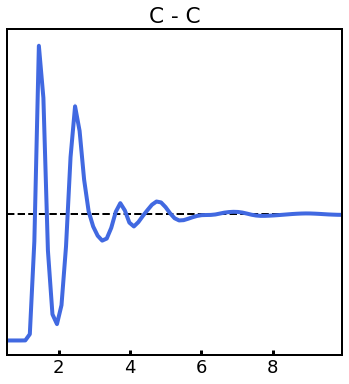

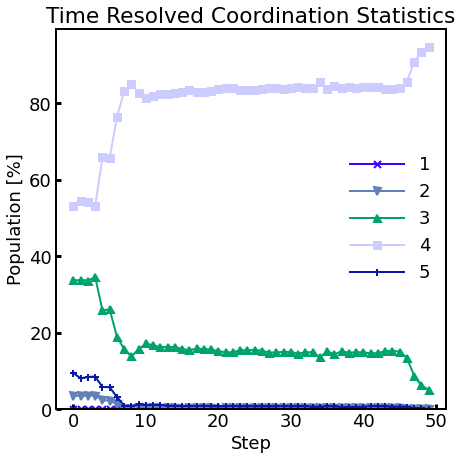

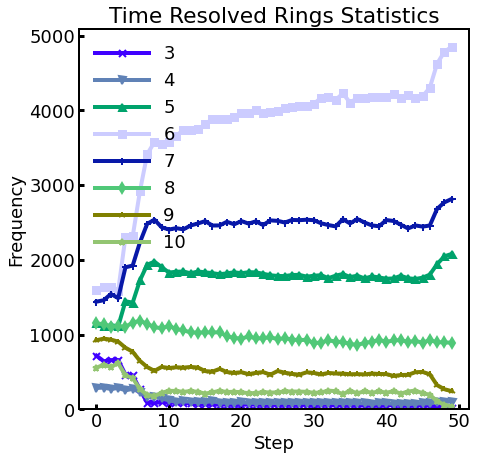

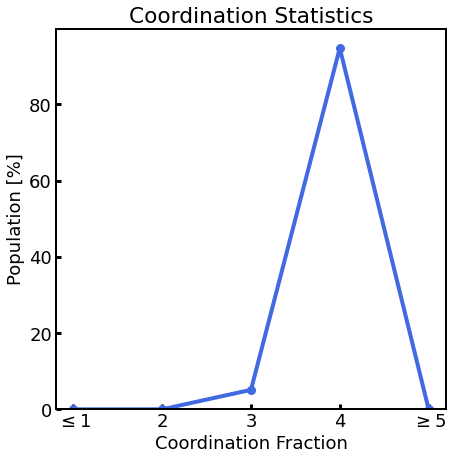

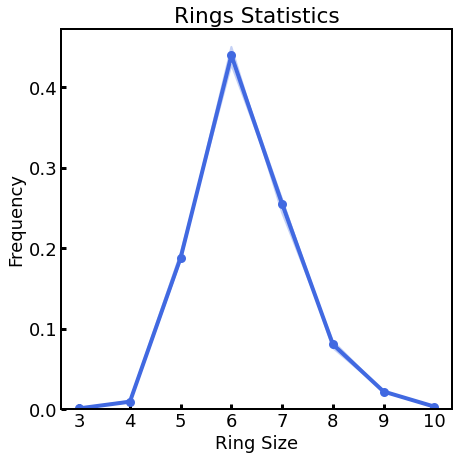

In [15]:
# Perform GAP Analysis
all_analysers = []

soap_string = "soap cutoff=4.5 l_max=6 n_max=9 atom_sigma=0.5 add_species=True, central_weight=0"

for dirname in test_dirs:
    
    print("\n" + 20 * '#' + '\n')
    print(dirname)
    
    name = dirname.split('/')[-1]
    print(name)
    if not os.path.exists(name):
        os.mkdir(name)
    
    print("Beginning to read trajectory for {}".format(dirname))
    test_analyser = CHO_Analyser([dirname], name=os.path.join(name, "Analysis_"))
    all_analysers.append(test_analyser)
    all_analysers[-1].read_trajectories(traj_type='xtc', engine='MDAnalysis', flatten=True)
    print("Done reading trajectories")
    
    print("beginning computation of rdfs")
    all_analysers[-1].compute_all_rdf()
    all_analysers[-1].plot_all_rdf()
    print("done computing rdfs")
    
    print("beginning computation of soap similarities")
    all_analysers[-1].compute_all_soap_similarities(soap_string, n_frames=50)
    all_analysers[-1].plot_all_soap_similarities()
    print("done computing soap similarities")
    
    print("beginning computation of rings and neighbours")
    all_analysers[-1].compute_all_rings_neighbours(selection=['C'], n_frames=50, n_skip=50)
    all_analysers[-1].plot_step_rings_neighbours()
    all_analysers[-1].plot_all_rings_neighbours()
    print("Done computing rings and neighbours")
    
    print("\n" + 20 * '#' + '\n')